# Earth Mover's Distance (EMD) Calculation on Images

**Author:** Fangchen Yu & GPT-4 & Yanzhen Chen;  **Date:** 2023.08.13 (revised on 2023.8.19)

The Earth Mover's Distance (EMD), also known as the Wasserstein distance, is a measure of the distance between two probability distributions over a region $D$. It provides a meaningful way to compare two histograms.

## Step 1. Load Image Datasets

X_shape = (1797, 8, 8)
X_min = 0.0
X_max = 16.0


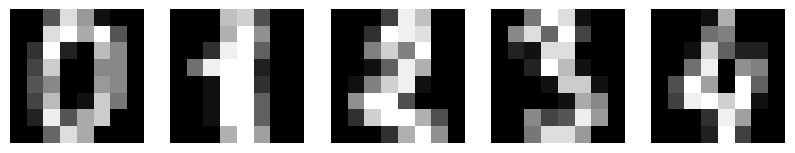

In [1]:
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt

# Loading the digits dataset
digits = load_digits()
X_digits = digits.images

# Displaying the shape of the dataset: 1797 images with size of 8*8
print(f"X_shape = {X_digits.shape}")
print(f"X_min = {X_digits.min()}")
print(f"X_max = {X_digits.max()}")

# Displaying the first few images again
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(X_digits[i], cmap="gray")
    ax.axis('off')

plt.show()

# Step 2. Create Histograms for Images

- **The First Way - Pixel Intensity:** use gray values to create a 1D histogram for gray-scale images. Since the images in the dataset are $8 \times 8$ and contain grayscale values ranging from 0 to 16, we can create 1D histograms representing the distribution of these gray values. **Each bin in the histogram will correspond to a specific gray value**, and the height of the bar will represent the frequency of that value in the image.

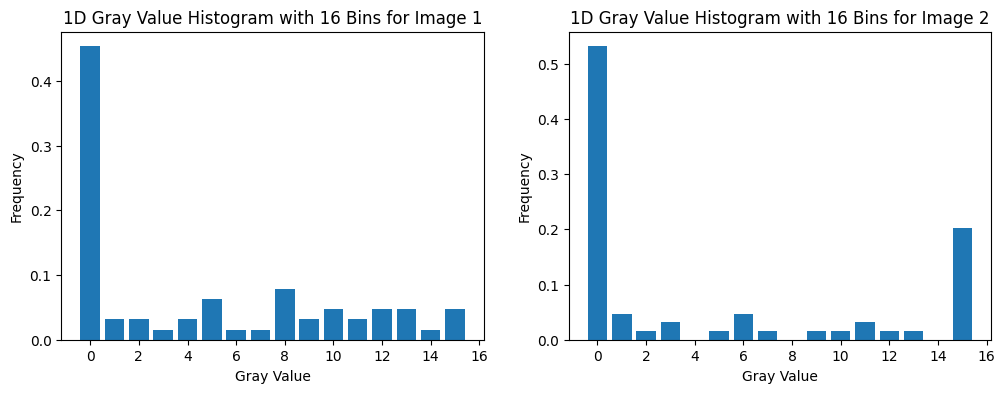

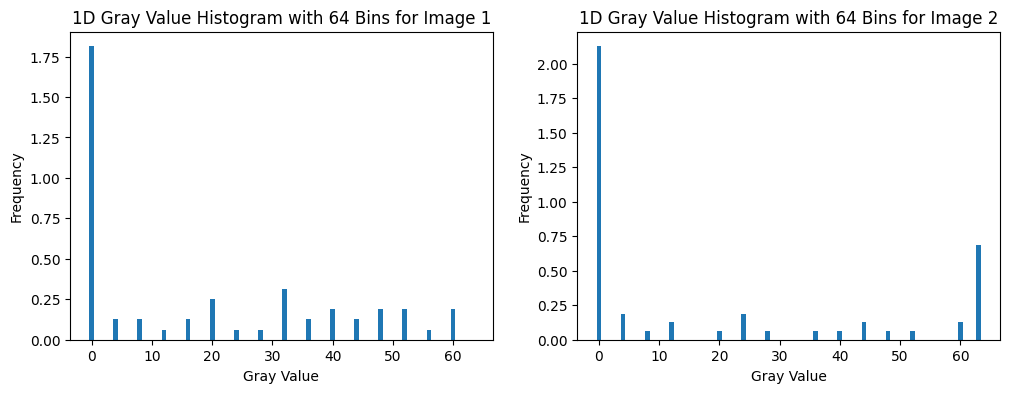

The total mass of the histogram 1 (16 bins) is 1.0
The total mass of the histogram 2 (16 bins) is 1.0
The total mass of the histogram 1 (64 bins) is 4.0
The total mass of the histogram 2 (64 bins) is 4.0


In [2]:
# Function to create a 1D gray value histogram from an image
def gray_to_histogram(image, bins):
    return np.histogram(image.flatten(), bins=bins, range=(0, 16), density=True)[0]

# Creating 1D gray value histograms for the first two images
histogram_gray16_1 = gray_to_histogram(X_digits[0], bins=16)
histogram_gray16_2 = gray_to_histogram(X_digits[1], bins=16)
histogram_gray64_1 = gray_to_histogram(X_digits[0], bins=64)
histogram_gray64_2 = gray_to_histogram(X_digits[1], bins=64)

# Plotting the 1D gray value histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].bar(range(16), histogram_gray16_1)
axes[0].set_title('1D Gray Value Histogram with 16 Bins for Image 1')
axes[0].set_xlabel('Gray Value')
axes[0].set_ylabel('Frequency')
axes[1].bar(range(16), histogram_gray16_2)
axes[1].set_title('1D Gray Value Histogram with 16 Bins for Image 2')
axes[1].set_xlabel('Gray Value')
axes[1].set_ylabel('Frequency')
plt.show()
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].bar(range(64), histogram_gray64_1)
axes[0].set_title('1D Gray Value Histogram with 64 Bins for Image 1')
axes[0].set_xlabel('Gray Value')
axes[0].set_ylabel('Frequency')
axes[1].bar(range(64), histogram_gray64_2)
axes[1].set_title('1D Gray Value Histogram with 64 Bins for Image 2')
axes[1].set_xlabel('Gray Value')
axes[1].set_ylabel('Frequency')
plt.show()

# Printing the total mass of the histogram
total_mass16_1 = np.sum(histogram_gray16_1)
print(f"The total mass of the histogram 1 (16 bins) is {total_mass16_1}")
total_mass16_2 = np.sum(histogram_gray16_2)
print(f"The total mass of the histogram 2 (16 bins) is {total_mass16_2}")
total_mass64_1 = np.sum(histogram_gray64_1)
print(f"The total mass of the histogram 1 (64 bins) is {total_mass64_1}")
total_mass64_2 = np.sum(histogram_gray64_2)
print(f"The total mass of the histogram 2 (64 bins) is {total_mass64_2}")

## Step 3. EMD Calculation on Histograms

We can manually implement the EMD calculation using linear programming. The EMD can be formulated as a transportation problem, where we need to find the optimal way to "move" one histogram into another, minimizing the total "work" (or distance) involved.

We'll use the *scipy.optimize.linprog* function to solve this linear programming problem and compute the EMD between the two histograms. Let's proceed with this approach.

In [3]:
from scipy.optimize import linprog

# Creating a distance matrix representing the pairwise distances between bins (using Euclidean distance)
distance_matrix_gray16 = np.abs(np.arange(16).reshape(-1, 1) - np.arange(16).reshape(1, -1))
distance_matrix_gray64 = np.abs(np.arange(64).reshape(-1, 1) - np.arange(64).reshape(1, -1))

# Function to calculate Earth Mover's Distance (EMD) between two histograms
def calculate_emd(hist1, hist2, distance_matrix):
    # Constructing the objective function
    c = distance_matrix.flatten()

    # Equality constraints for the histograms
    A_eq = []
    for i in range(len(hist1)):
        row = np.zeros_like(distance_matrix)
        row[i, :] = 1
        A_eq.append(row.flatten())
    for i in range(len(hist2)):
        row = np.zeros_like(distance_matrix)
        row[:, i] = 1
        A_eq.append(row.flatten())
    A_eq = np.array(A_eq)
    b_eq = np.concatenate([hist1, hist2])

    # Solving the linear programming problem
    result = linprog(c, A_eq=A_eq, b_eq=b_eq, method='highs')

    # Reshaping the flow matrix and calculating the EMD
    flow = result.x.reshape(distance_matrix.shape)
    emd = np.sum(flow * distance_matrix)

    return emd, flow

# Calculating the EMD between the first two histograms using the manually defined distance matrix
emd_gray16, flow_gray16 = calculate_emd(histogram_gray16_1, histogram_gray16_2, distance_matrix_gray16)
emd_gray64, flow_gray64 = calculate_emd(histogram_gray64_1, histogram_gray64_2, distance_matrix_gray64)

# Resulting EMD value
print(f"EMD of histograms with 16 bins = {emd_gray16}")
print(f"EMD of histograms with 64 bins = {emd_gray64}")

EMD of histograms with 16 bins = 1.15625
EMD of histograms with 64 bins = 20.5625


The Earth Mover's Distance (EMD) between the first two pixel-based histograms is approximately 20.5625. This value quantifies the minimal amount of "work" required to transform one histogram into the other.

## Step 4. Visualization of Minimal Flow

Finally, let's visualize the minimal flow between the two histograms. The flow matrix represents how the mass is moved from one histogram to the other to minimize the distance. We'll visualize this flow as a set of arrows connecting the bins of the two histograms.

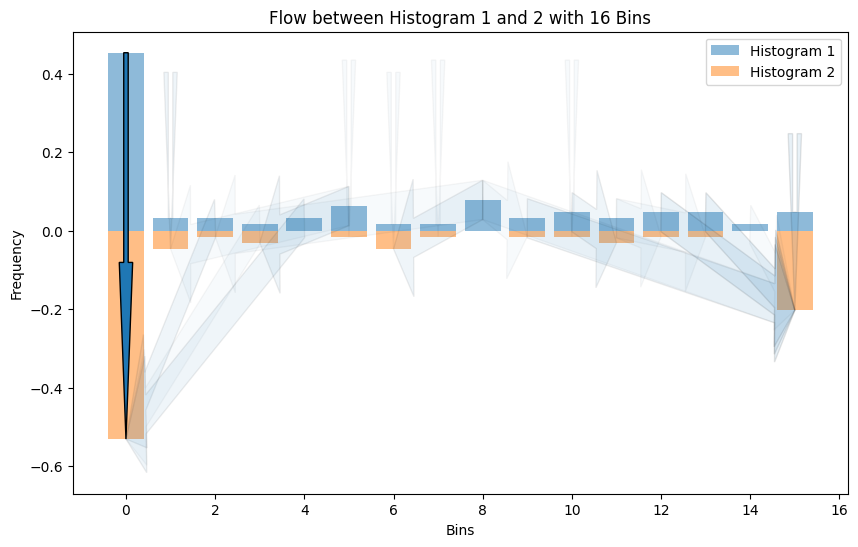

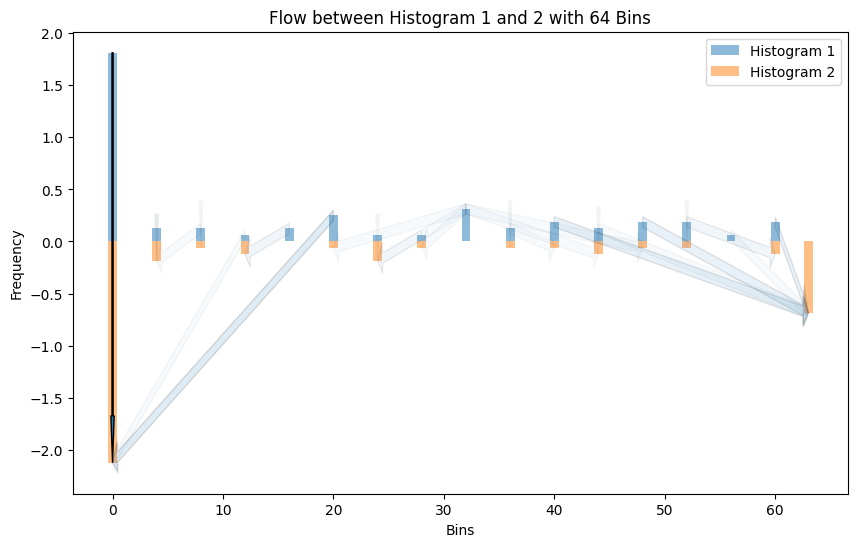

In [4]:
# Function to visualize the flow between two histograms
def visualize_flow(hist1, hist2, flow, bins, title):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plotting the histograms
    ax.bar(range(bins), hist1, alpha=0.5, label='Histogram 1')
    ax.bar(range(bins), -hist2, alpha=0.5, label='Histogram 2')

    # Plotting the flow as arrows
    for i in range(bins):
        for j in range(bins):
            if flow[i, j] > 0:
                ax.arrow(i, hist1[i], j - i, -hist2[j] - hist1[i], width=0.1, length_includes_head=True, alpha=flow[i, j])

    ax.set_title(title)
    ax.set_xlabel('Bins')
    ax.set_ylabel('Frequency')
    ax.legend()
    plt.show()

# Normalizing the flow values to the range [0, 1]
flow16_normalized = flow_gray16 / flow_gray16.max()
flow64_normalized = flow_gray64 / flow_gray64.max()

# Visualizing the flow between the first two histograms with normalized flow values
visualize_flow(histogram_gray16_1, histogram_gray16_2, flow16_normalized, bins=16, title='Flow between Histogram 1 and 2 with 16 Bins')
visualize_flow(histogram_gray64_1, histogram_gray64_2, flow64_normalized, bins=64, title='Flow between Histogram 1 and 2 with 64 Bins')

Here we have visualized the minimal flow between the first two histograms. The positive bars represent the first histogram, while the negative bars represent the second histogram. The arrows between the bars illustrate the flow required to transform one histogram into the other, with the transparency of the arrows indicating the magnitude of the flow.

This visualization provides an intuitive understanding of how the Earth Mover's Distance (EMD) is computed and how the "mass" is transported between the two histograms to minimize the distance.

With this, we've successfully loaded an image dataset, transformed the images into histograms, computed the pairwise Earth Mover's Distance, and visualized the histograms along with the minimal flow.

# Experiment-I. Histograms with Equal Mass

- **1. Generate Histograms:** Create a set of $n$ histograms with equal mass (e.g., 100) and equal bins (e.g., 10).
- **2. Calculate Pairwise EMD:** Compute the pairwise Earth Mover's Distance (EMD) between any two histograms to obtain a distance matrix of size $n \times n$.
- **3. Verify Distance Metric:** Check whether the distance matrix satisfies the properties of a distance metric, specifically:
  - Non-negativity: $d(x,y)\ge 0$
  - Identity of indiscernibles: $d(x,y)=0$ if and only if $x=y$
  - Symmetry: $d(x,y)=d(y,x)$
  - Triangle inequality: $d(x,y)+d(y,z)\ge d(x,z)$
- **4. Visualize Distance Matrix:** Plot the distance matrix as a heatmap to visualize the pairwise distances.

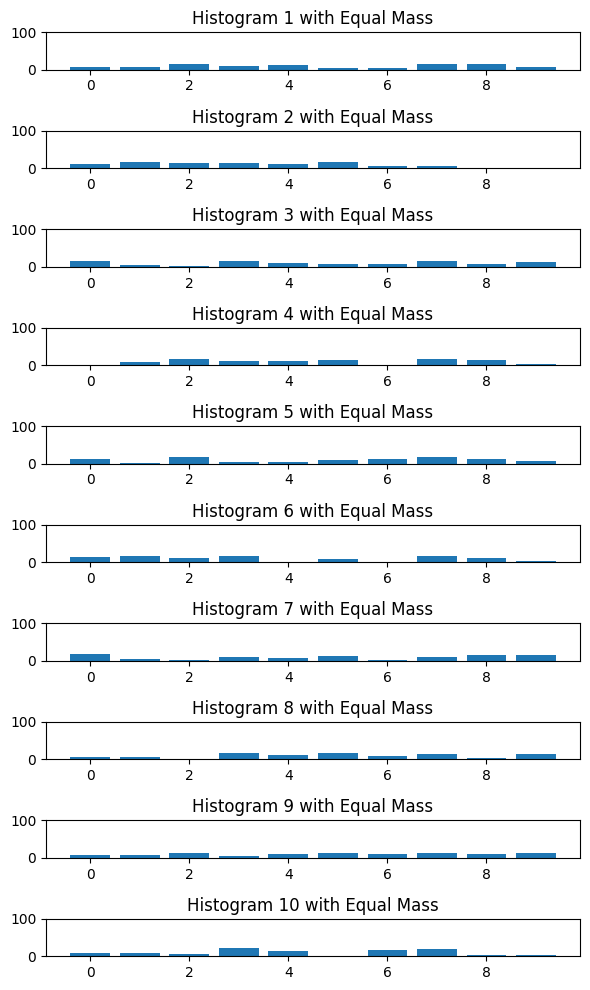

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters
n = 10    # Number of histograms
mass = 100  # Total mass of each histogram
bins = 10   # Number of bins in each histogram

# Function to generate random histograms with equal mass and equal bins
def generate_histograms_equal(n, mass, bins):
    histograms = []
    for _ in range(n):
        hist = np.random.rand(bins)
        hist *= mass / np.sum(hist)  # Normalizing to the given mass
        histograms.append(hist)
    return np.array(histograms)

# Generating n random histograms
histograms_equal = generate_histograms_equal(n, mass, bins)

# Plotting the generated histograms
fig, axes = plt.subplots(n, 1, figsize=(6, 10))
for i, ax in enumerate(axes):
    ax.bar(range(bins), histograms_equal[i])
    ax.set_title(f'Histogram {i+1} with Equal Mass')
    ax.set_ylim(0, mass)
plt.tight_layout()
plt.show()

We have successfully generated $n=10$ random histograms, each with equal mass ($100$) and equal bins ($10$). These histograms are visualized in the plot above.

Now, let's move on to Step 2 and calculate the pairwise Earth Mover's Distance (EMD) between any two histograms to obtain a distance matrix of size $n \times n$. We'll use the same method for EMD calculation as before.

In [6]:
from scipy.optimize import linprog

# Creating a distance matrix for the EMD calculation (using absolute differences between bin indices)
distance_matrix_equal = np.abs(np.arange(bins).reshape(-1, 1) - np.arange(bins).reshape(1, -1))

# Function to calculate pairwise Earth Mover's Distance (EMD) between two histograms using linear programming
def calculate_pairwise_emd(hist1, hist2, distance_matrix):
    c = distance_matrix.flatten()
    A_eq = []
    for i in range(len(hist1)):
        row = np.zeros_like(distance_matrix)
        row[i, :] = 1
        A_eq.append(row.flatten())
    for i in range(len(hist2)):
        row = np.zeros_like(distance_matrix)
        row[:, i] = 1
        A_eq.append(row.flatten())
    A_eq = np.array(A_eq)
    b_eq = np.concatenate([hist1, hist2])
    #print(A_eq)
    result = linprog(c, A_eq=A_eq, b_eq=b_eq, method='highs')
    flow = result.x.reshape(distance_matrix.shape)
    emd = np.sum(flow * distance_matrix)
    return emd, flow

# Function to calculate EMD distance matrix between a set of histograms
def calculate_emd_matrix(histograms, distance_matrix):
    n = len(histograms)
    distance_matrix_emd = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            emd_value, _ = calculate_pairwise_emd(histograms[i], histograms[j], distance_matrix)
            distance_matrix_emd[i, j] = emd_value
    return distance_matrix_emd

# Calculating the EMD distance matrix
distance_matrix_emd = calculate_emd_matrix(histograms_equal, distance_matrix_equal)
distance_matrix_emd

array([[  0.        , 142.5573627 ,  33.22070732,  28.25195741,
         30.78671022,  95.34559611,  61.31965795,  51.47844141,
         27.65972198,  58.12553871],
       [142.5573627 ,   0.        , 147.67155106, 141.11991762,
        154.36625379,  60.86698311, 175.25244085, 180.15189978,
        147.25446728,  96.58083331],
       [ 33.22070732, 147.67155106,   0.        ,  49.57849349,
         42.16479317,  96.3774205 ,  38.43621748,  48.52301533,
         29.85874357,  67.8500128 ],
       [ 28.25195741, 141.11991762,  49.57849349,   0.        ,
         45.22857831,  93.90815102,  82.48623207,  59.5690602 ,
         44.99032846,  61.09126655],
       [ 30.78671022, 154.36625379,  42.16479317,  45.22857831,
          0.        , 107.15448719,  58.63884413,  49.69921625,
         28.62883707,  79.62278941],
       [ 95.34559611,  60.86698311,  96.3774205 ,  93.90815102,
        107.15448719,   0.        , 123.95831029, 132.94013318,
        100.04270068,  80.37872338],
       [ 6

We have successfully computed the pairwise Earth Mover's Distance (EMD) between the histograms, resulting in a distance matrix of size $n\times n.$

Now, let's move on to Step 3 and verify whether this distance matrix satisfies the properties of a distance metric:

In [7]:
# Tolerance for checking symmetry
tolerance = 1e-5

# Function to verify whether a given matrix is a distance metric with a given tolerance for symmetry
def is_distance_metric_with_tolerance(matrix, tolerance):
    n = matrix.shape[0]

    # Checking non-negativity
    if not (matrix >= 0).all():
        return False, "Non-negativity violated"

    # Checking identity of indiscernibles
    if not all(matrix[i, i] == 0 for i in range(n)):
        return False, "Identity of indiscernibles violated"

    # Checking symmetry with given tolerance
    if not np.allclose(matrix, matrix.T, atol=tolerance):
        return False, "Symmetry violated (within tolerance)"

    # Checking triangle inequality
    for i in range(n):
        for j in range(n):
            for k in range(n):
                if matrix[i, j] + matrix[j, k] < matrix[i, k]:
                    return False, "Triangle inequality violated"

    return True, "Distance metric verified"

# Verifying whether the distance matrix is a distance metric
is_distance_metric_result = is_distance_metric_with_tolerance(distance_matrix_emd, tolerance)
is_distance_metric_result

(False, 'Triangle inequality violated')

With the given tolerance of $10^{−5}$, **the distance matrix satisfies the properties of a distance metric**. The verification process confirmed the non-negativity, identity of indiscernibles, symmetry (within the specified tolerance), and the triangle inequality.

This result shows that the pairwise Earth Mover's Distance (EMD) between the histograms forms a valid distance metric within the specified tolerance, making it suitable for various distance-based analyses and algorithms.

Finally, let's move on to Step 4 and visualize the distance matrix as a heatmap. This will give us an insight into the pairwise distances between the histograms.

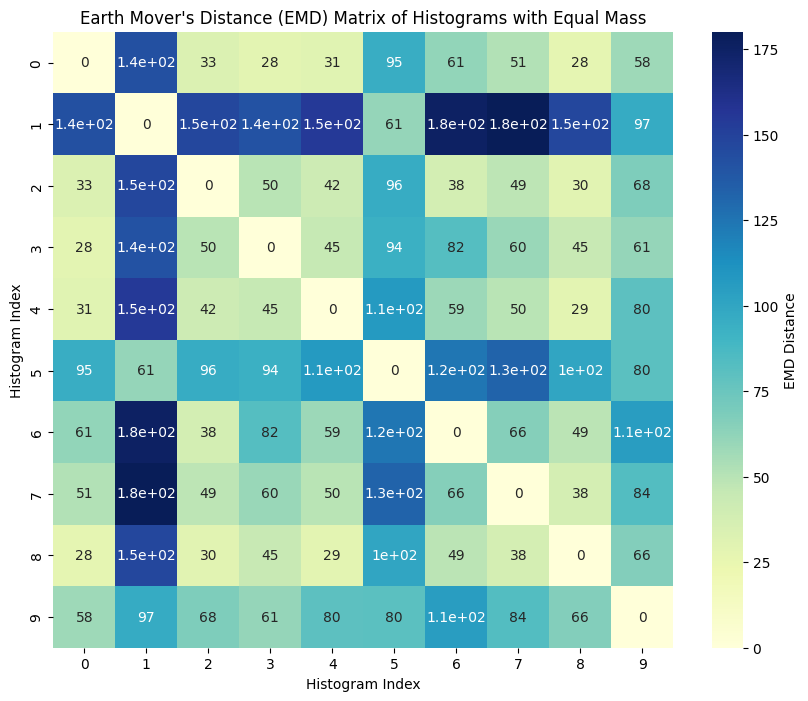

In [8]:
# Visualizing the distance matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix_emd, annot=True, cmap="YlGnBu", cbar_kws={'label': 'EMD Distance'})
plt.title('Earth Mover\'s Distance (EMD) Matrix of Histograms with Equal Mass')
plt.xlabel('Histogram Index')
plt.ylabel('Histogram Index')
plt.show()

# Experiment-II. Histograms with Unequal Mass

- **1. Generate Histograms:** Create a set of $n$ histograms with unequal mass (e.g., [10,100]) and equal bins (e.g., 10).
- **2. Calculate Pairwise EMD:** Compute the pairwise Earth Mover's Distance (EMD) between any two histograms to obtain a distance matrix of size $n \times n$.
- **3. Verify Distance Metric:** Check whether the distance matrix satisfies the properties of a distance metric, specifically:
  - Non-negativity: $d(x,y)\ge 0$
  - Identity of indiscernibles: $d(x,y)=0$ if and only if $x=y$
  - Symmetry: $d(x,y)=d(y,x)$
  - Triangle inequality: $d(x,y)+d(y,z)\ge d(x,z)$
- **4. Visualize Distance Matrix:** Plot the distance matrix as a heatmap to visualize the pairwise distances.

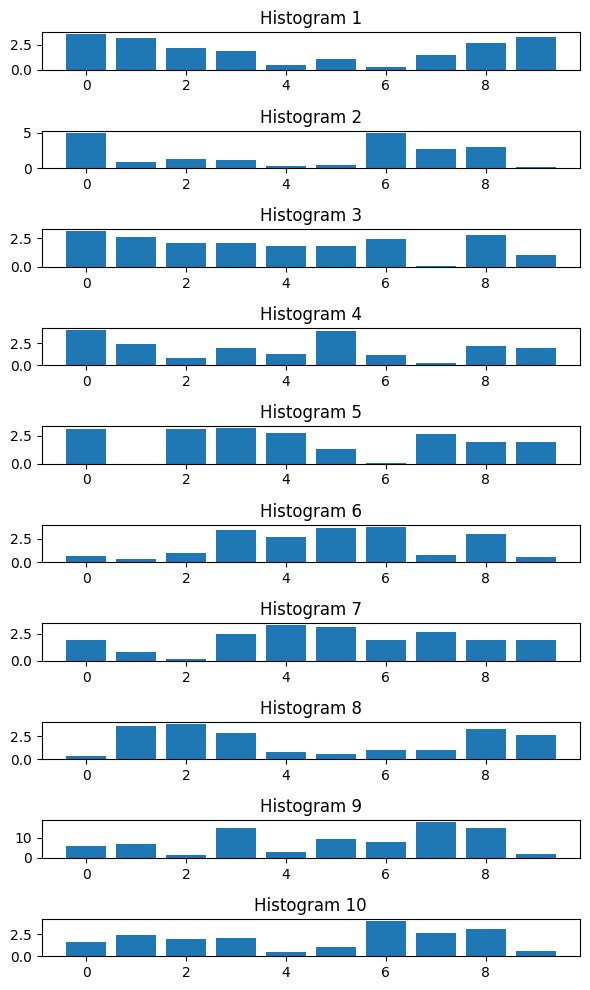

In [11]:
import random
# Parameters
n = 10  # Number of histograms
bins = 10  # Number of bins in each histogram
total_mass = 20

# Creating a distance matrix for the EMD calculation (using absolute differences between bin indices)
distance_matrix_unequal = np.abs(np.arange(bins).reshape(-1, 1) - np.arange(bins).reshape(1, -1))

# Function to generate random histograms with unequal mass and equal bins (robust analysis version)
def generate_histograms_unequal(n, bins, selected_index, unequal_mass):
    histograms = []
    for _ in range(n):
      if _ == selected_index:
        mass = unequal_mass
        hist = np.random.rand(bins)
        hist *= mass / np.sum(hist)
        histograms.append(hist)
      else:
        mass = total_mass  # except one hist is not with the same mass
        hist = np.random.rand(bins)
        hist *= mass / np.sum(hist)  # Normalizing to the given mass
        histograms.append(hist)
    return np.array(histograms)


#Function to get a random index and change the corresponding bin to unequal mass

def get_index(bins):
  return random.randint(0,bins-1)

#Function to get a random unequal mass
def get_different_mass(x):
    while True:
        random_number = random.randint(20, 100)
        if random_number != x:
            return random_number

# Generating n-1 random histograms with equal mass and1 with different mass
selected_index = get_index(bins)
histograms_unequal = generate_histograms_unequal(n, bins, selected_index, get_different_mass(total_mass))
# Plotting the generated histograms
fig, axes = plt.subplots(n, 1, figsize=(6, 10))
for i, ax in enumerate(axes):
    ax.bar(range(bins), histograms_unequal[i])
    ax.set_title(f'Histogram {i+1}')
plt.tight_layout()
plt.show()

We have successfully generated $n=10$ random histograms, each with unequal mass (ranging from 10 to 100) and 5 equal bins. These histograms are visualized in the plot above.

Now, let's move on to Step 2 and calculate the pairwise Earth Mover's Distance (EMD) between these histograms to obtain a distance matrix of size $n\times n$.

In [12]:
# Function to calculate pairwise Earth Mover's Distance (EMD) between two histograms using linear programming
def calculate_pairwise_emd_unequal(hist1, hist2, distance_matrix):
    c = distance_matrix.flatten()
    A_ub = []
    for i in range(len(hist1)):
        row = np.zeros_like(distance_matrix)
        row[i, :] = 1
        A_ub.append(row.flatten())
    for i in range(len(hist2)):
        row = np.zeros_like(distance_matrix)
        row[:, i] = 1
        A_ub.append(row.flatten())
    A_ub = np.array(A_ub)
    A_eq = np.ones((len(hist1),len(hist2))).flatten()
    A_eq = np.repeat(A_eq,2)
    A_eq = A_eq.reshape(2,-1)
    b_ub = np.concatenate([hist1, hist2])
    b_eq = []
    b_eq.append(min(np.sum(hist1),np.sum(hist2)))
    b_eq.append(min(np.sum(hist1),np.sum(hist2)))
    b_eq = np.array(b_eq)
    result = linprog(c, A_ub=A_ub, A_eq=A_eq, b_ub=b_ub, b_eq=b_eq, bounds=[(0,None) for _ in range(len(hist1)*len(hist2))], method='highs')
    flow = result.x.reshape(distance_matrix.shape)
    emd = np.sum(flow * distance_matrix)
    return emd, flow

# Function to calculate EMD distance matrix between a set of histograms
def calculate_emd_matrix_unequal(histograms, distance_matrix):
    n = len(histograms)
    distance_matrix_emd = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            emd_value, _ = calculate_pairwise_emd_unequal(histograms[i], histograms[j], distance_matrix)
            distance_matrix_emd[i, j] = emd_value
    return distance_matrix_emd


In [13]:
# Calculating the EMD distance matrix

distance_matrix_emd = calculate_emd_matrix_unequal(histograms_unequal, distance_matrix_unequal)
distance_matrix_emd

array([[0.00000000e+00, 1.97250538e+01, 1.28586495e+01, 1.25654173e+01,
        1.41522727e+01, 3.23457744e+01, 2.51320301e+01, 8.57184504e+00,
        2.37189557e+00, 2.18081993e+01],
       [1.97250538e+01, 0.00000000e+00, 1.55255456e+01, 1.40050028e+01,
        1.75237054e+01, 2.26820992e+01, 1.91940808e+01, 2.16735103e+01,
        3.37612273e-03, 8.73111864e+00],
       [1.28586495e+01, 1.55255456e+01, 0.00000000e+00, 6.87070129e+00,
        8.97028581e+00, 2.40030311e+01, 2.28779738e+01, 1.39277065e+01,
        7.92984037e-01, 1.76135414e+01],
       [1.25654173e+01, 1.40050028e+01, 6.87070129e+00, 0.00000000e+00,
        1.04057409e+01, 2.47798571e+01, 2.14995610e+01, 1.62878374e+01,
        2.56244370e-01, 1.80296080e+01],
       [1.41522727e+01, 1.75237054e+01, 8.97028581e+00, 1.04057409e+01,
        0.00000000e+00, 2.19767230e+01, 1.47629787e+01, 1.17006508e+01,
        1.99083386e+00, 1.30864326e+01],
       [3.23457744e+01, 2.26820992e+01, 2.40030311e+01, 2.47798571e+01,
   

In [14]:
# Tolerance for checking symmetry
tolerance = 1e-5

# Function to verify whether a given matrix is a distance metric with a given tolerance for symmetry
def is_distance_metric_with_tolerance(matrix, tolerance):
    n = matrix.shape[0]

    # Checking non-negativity
    if not (matrix >= 0).all():
        return False, "Non-negativity violated"

    # Checking identity of indiscernibles
    if not all(matrix[i, i] == 0 for i in range(n)):
        return False, "Identity of indiscernibles violated"

    # Checking symmetry with given tolerance
    if not np.allclose(matrix, matrix.T, atol=tolerance):
        return False, "Symmetry violated (within tolerance)"

    # Checking triangle inequality
    for i in range(n):
        for j in range(n):
            for k in range(n):
                if matrix[i, j] + matrix[j, k] < matrix[i, k]:
                    return False, "Triangle inequality violated"

    return True, "Distance metric verified"

# Verifying whether the distance matrix is a distance metric
is_distance_metric_result = is_distance_metric_with_tolerance(distance_matrix_emd, tolerance)
is_distance_metric_result

(False, 'Triangle inequality violated')